# 0.0 IMPORTS, FUNCTIONS AND CONNECTIONS

## 0.1 PACKAGES AND LIBRARIES

In [62]:
import pandas as pd
import psycopg2 as pg
import seaborn as sns
import pickle
import warnings
import dotenv
import os

from matplotlib import pyplot as plt
from collections import Counter
from sqlalchemy import create_engine

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE

from IPython.core.display import HTML
from IPython.display import Image

## 0.2 Helper Function

In [63]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [64]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3 Database Connections

### 0.3.1 Database load files (sqlalchemy and psycopg2)

In [65]:
#dotenv.load_dotenv(dotenv.find_dotenv())
#url_sql = os.getenv('url_sql')
#engine = create_engine(url_sql)

#host = os.getenv('PA004_HOST')
#port = os.getenv('PA004_PORT')
#dbname = os.getenv('PA004_DATABASE')
#username = os.getenv('PA004_USERNAME')
#password = os.getenv('PA004_PASSWORD')

#conn = pg.connect(host=host, port=port, dbname=dbname, user=username, password=password)

#cur = conn.cursor()

In [66]:
#sql_query = '''
#SELECT u.id, u.age, u.region_code, u.policy_sales_channel,
#       i.previously_insured, i.annual_premium, i.vintage, i.response,
#       v.driving_license, v.vehicle_age, v.vehicle_damage
#       FROM pa004.users u LEFT JOIN pa004.insurance i ON (u.id = i.id)
#                          LEFT JOIN pa004.vehicle v  ON (u.id = v.id)                   
#                          '''
#cur.execute(sql_query)
#df_raw = pd.read_sql_query(sql_query, con=engine)

#cur.close()
#conn.close()

### 0.3.2 Database load files (Pandas)

In [67]:
df_raw = pd.read_csv('datasets/insurance_data.csv')

In [68]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,7,Male,23,11.0,152.0,0,23367.0,249,0,1,< 1 Year,Yes
1,13,Female,41,15.0,14.0,1,31409.0,221,0,1,1-2 Year,No
2,18,Female,25,35.0,152.0,1,46622.0,299,0,1,< 1 Year,No
3,31,Female,26,8.0,160.0,0,2630.0,136,0,1,< 1 Year,No
4,39,Male,45,8.0,124.0,0,42297.0,264,0,1,1-2 Year,Yes


# 1.0 DATA DESCRIPTION

In [69]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [70]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 381109
Number of Columns: 12


## 1.2 Changing Data Types

In [71]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

In [72]:
df1['region_code'] = df1['region_code'].astype(int64)

df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int64)

df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

## 1.3 Check NA

In [73]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4 Numerical Data Description

In [74]:
# Data Selection
df1_num = df1.select_dtypes(include=['int64', 'float64'])

#Central Tendency
ct1 = pd.DataFrame(df1_num.apply(np.mean)).T
ct2 = pd.DataFrame(df1_num.apply(np.median)).T

#Dispersion 
d1 = pd.DataFrame(df1_num.apply(min)).T
d2 = pd.DataFrame(df1_num.apply(max)).T
d3 = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1_num.apply(np.std)).T
d5 = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

df_descript = pd.concat([d1, d2, d3, ct1, ct2, d4, d5, d6]).T
df_descript.columns = ['min','max', 'range', 'average', 'median', 'std', 'skew', 'kurtosis']
df_descript

,min,max,range,average,median,std,skew,kurtosis
id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-1.950724e-02,-1.999630


## 1.5 Categorical Data Description

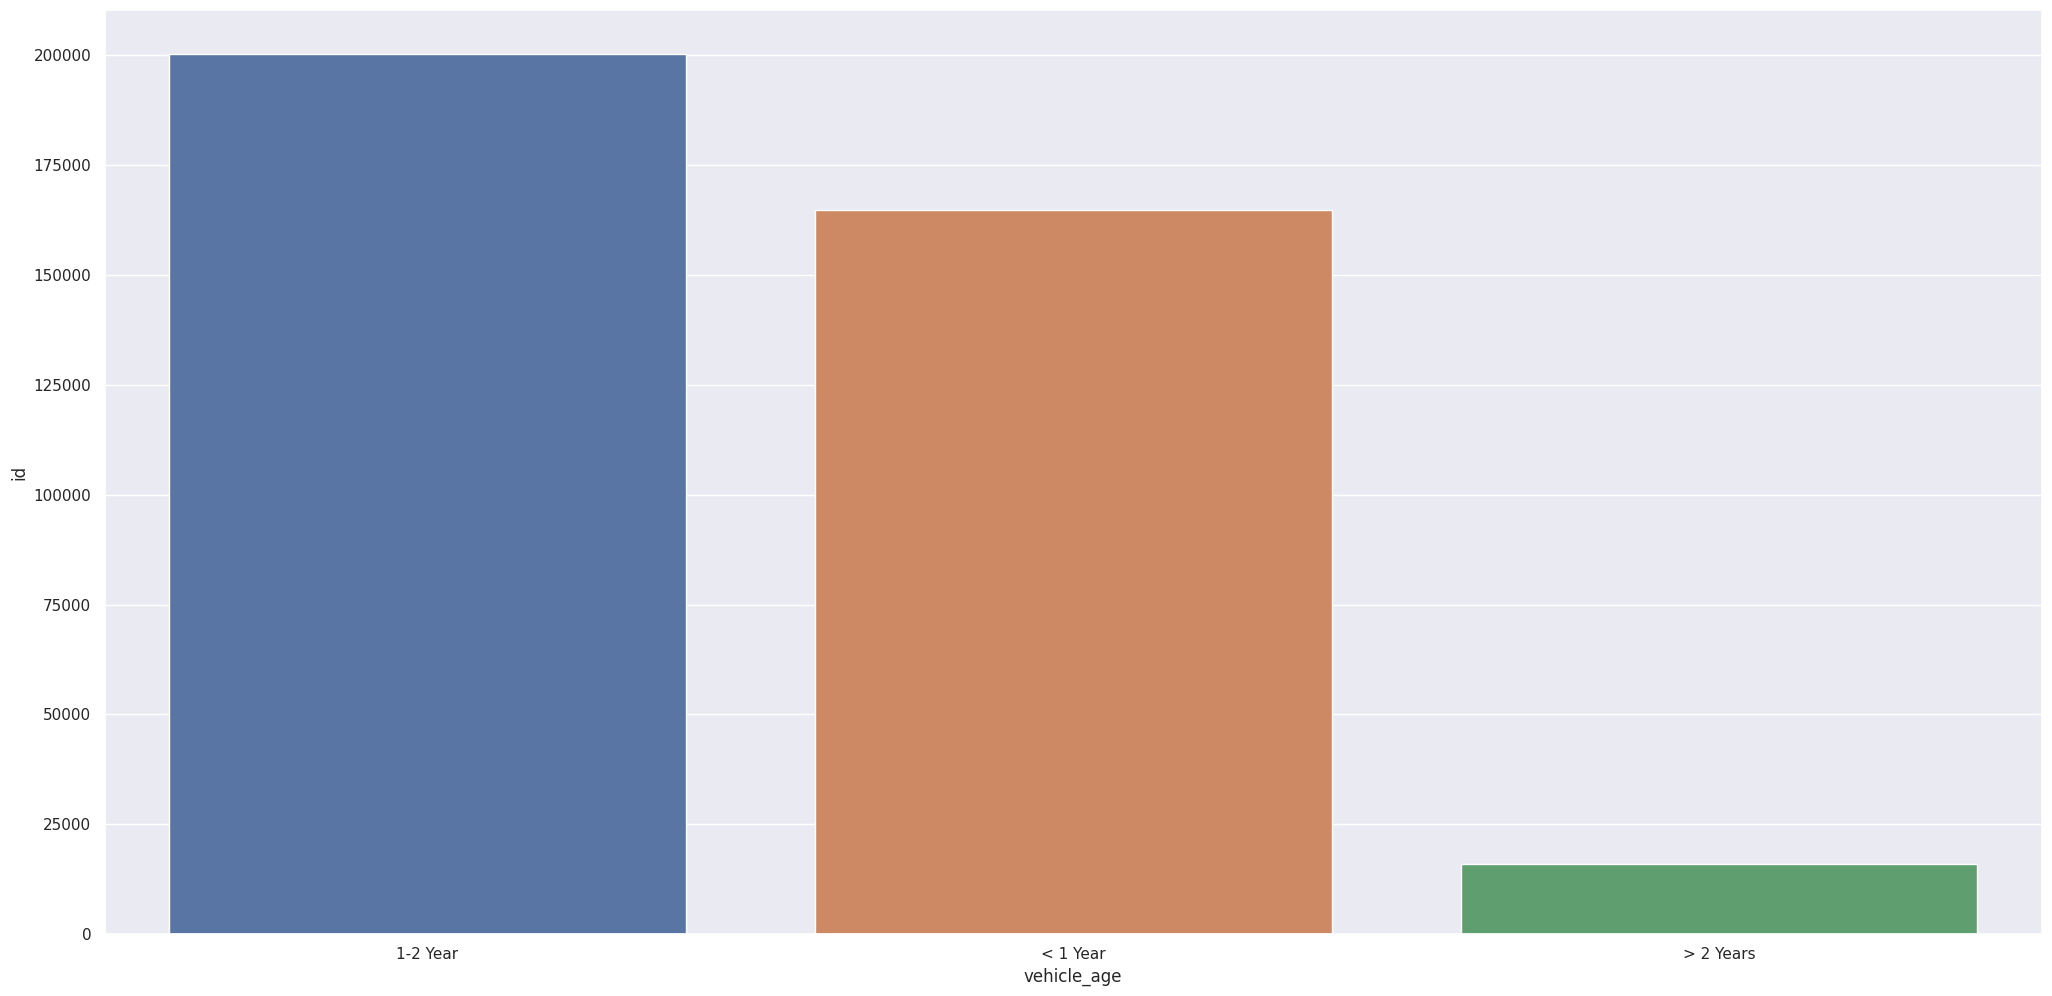

In [75]:
df_cat = df1[['vehicle_age', 'id']].groupby('vehicle_age').count().reset_index()

sns.barplot(data=df_cat, x='vehicle_age', y='id');

# 2.0 HYPOTHESIS TEST

In [76]:
df2 = df1.copy()
reorder_columns = ['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'response']

df2 = df2.reindex(columns=reorder_columns)

## 2.1 Hypothesis Mindmap

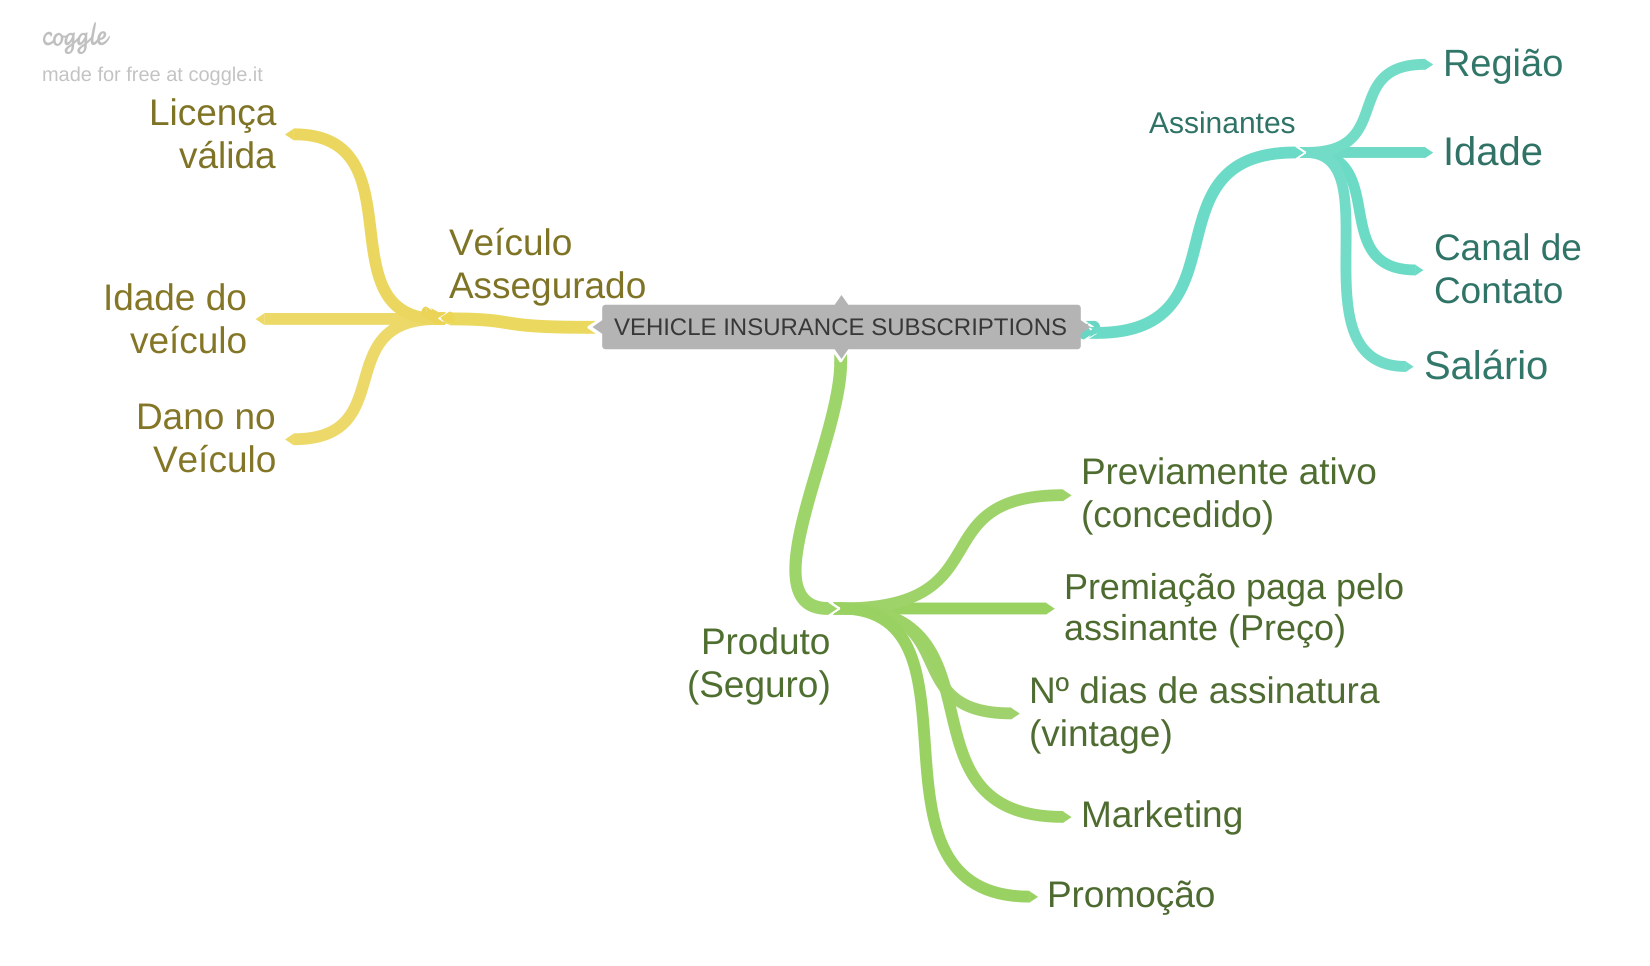

In [77]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses de Assinantes

1. Quanto maior a idade, maior propensão do cliente adquirir um plano seguro de saúde.
2. Quanto maior o salário, maior a propensão do cliente a adquirir um plano de seguro de saúde.
3. Quanto mais próx a um centro urbano(região), maior a propensão do cliente adquirir um plano de seguro de saúde.
    *Há alguma região com maior compra de aquisição de seguros?

### 2.2.2 Hipótese do Produto (Assinatura de seguro veícular)

1. Clientes que já ativaram/possuem o seguro veícular possuem menor propensão de adquirir um  novo plano de seguro veícular.
2. Clientes que pagam mais caro pela assinatura possuem menor propensão a adquirir um plano de saúde.
3. Clientes com mais dias de assinatura possuem maior propensão a adquirir um plano de saúde.
4. Clientes ficam mais propensos a assinar um plano de saúde conjunto após a realização de campanhas de marketing.
5. Clientes ficam mais propensos a assinar um plano de saúde com a realização de promoção conjunta ao plano de seguro veícular.

### 2.2.3 Hipóteses do Veículo em Seguridade

1. Clientes com a licença de habilitação são mais propensos a adquirir um plano de seguro de saúde.
2. Clientes com veículos mais antigos são mais propensos a adquirir um plano de seguro de saúde.
3. Clientes com veículos já danificados são mais propensos a adquirir um plano de seguro de saúde.

## 2.3 Hipóteses Selecionadas

1. Quanto maior a idade, maior propensão do cliente adquirir um plano seguro veícular.

2. Clientes que já ativaram/possuem o seguro veícular possuem menor propensão de adquirir um  novo plano de seguro veícular.
3. Clientes que pagam mais caro pela assinatura possuem menor propensão a adquirir um plano de seguro veícular.
4. Clientes com mais dias de assinatura possuem maior propensão a adquirir um plano de seguro veícular.

5. Clientes com licença de habilitação são mais propensos a adquirir um plano de seguro veícular.
6. Clientes com veículos mais antigos são mais propensos a adquirir um plano de seguro veícular.
7. Clientes com veículos já danificados são mais propensos a adquirir um plano de seguro veícular.

8. Clientes de determinada região são mais propensos a adquirir um plano de seguro veícular.

In [78]:
df2.head()

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,23,11,152,0,23367.0,249,1,< 1 Year,1,0
1,13,41,15,14,1,31409.0,221,1,1-2 Year,0,0
2,18,25,35,152,1,46622.0,299,1,< 1 Year,0,0
3,31,26,8,160,0,2630.0,136,1,< 1 Year,0,0
4,39,45,8,124,0,42297.0,264,1,1-2 Year,1,0


# 3.0 Exploratory Data Analysis & Feature Engineering

In [79]:
df3 = df2.copy()

## 3.1 Análise Univariada

### 3.1.1 Variável Numérica

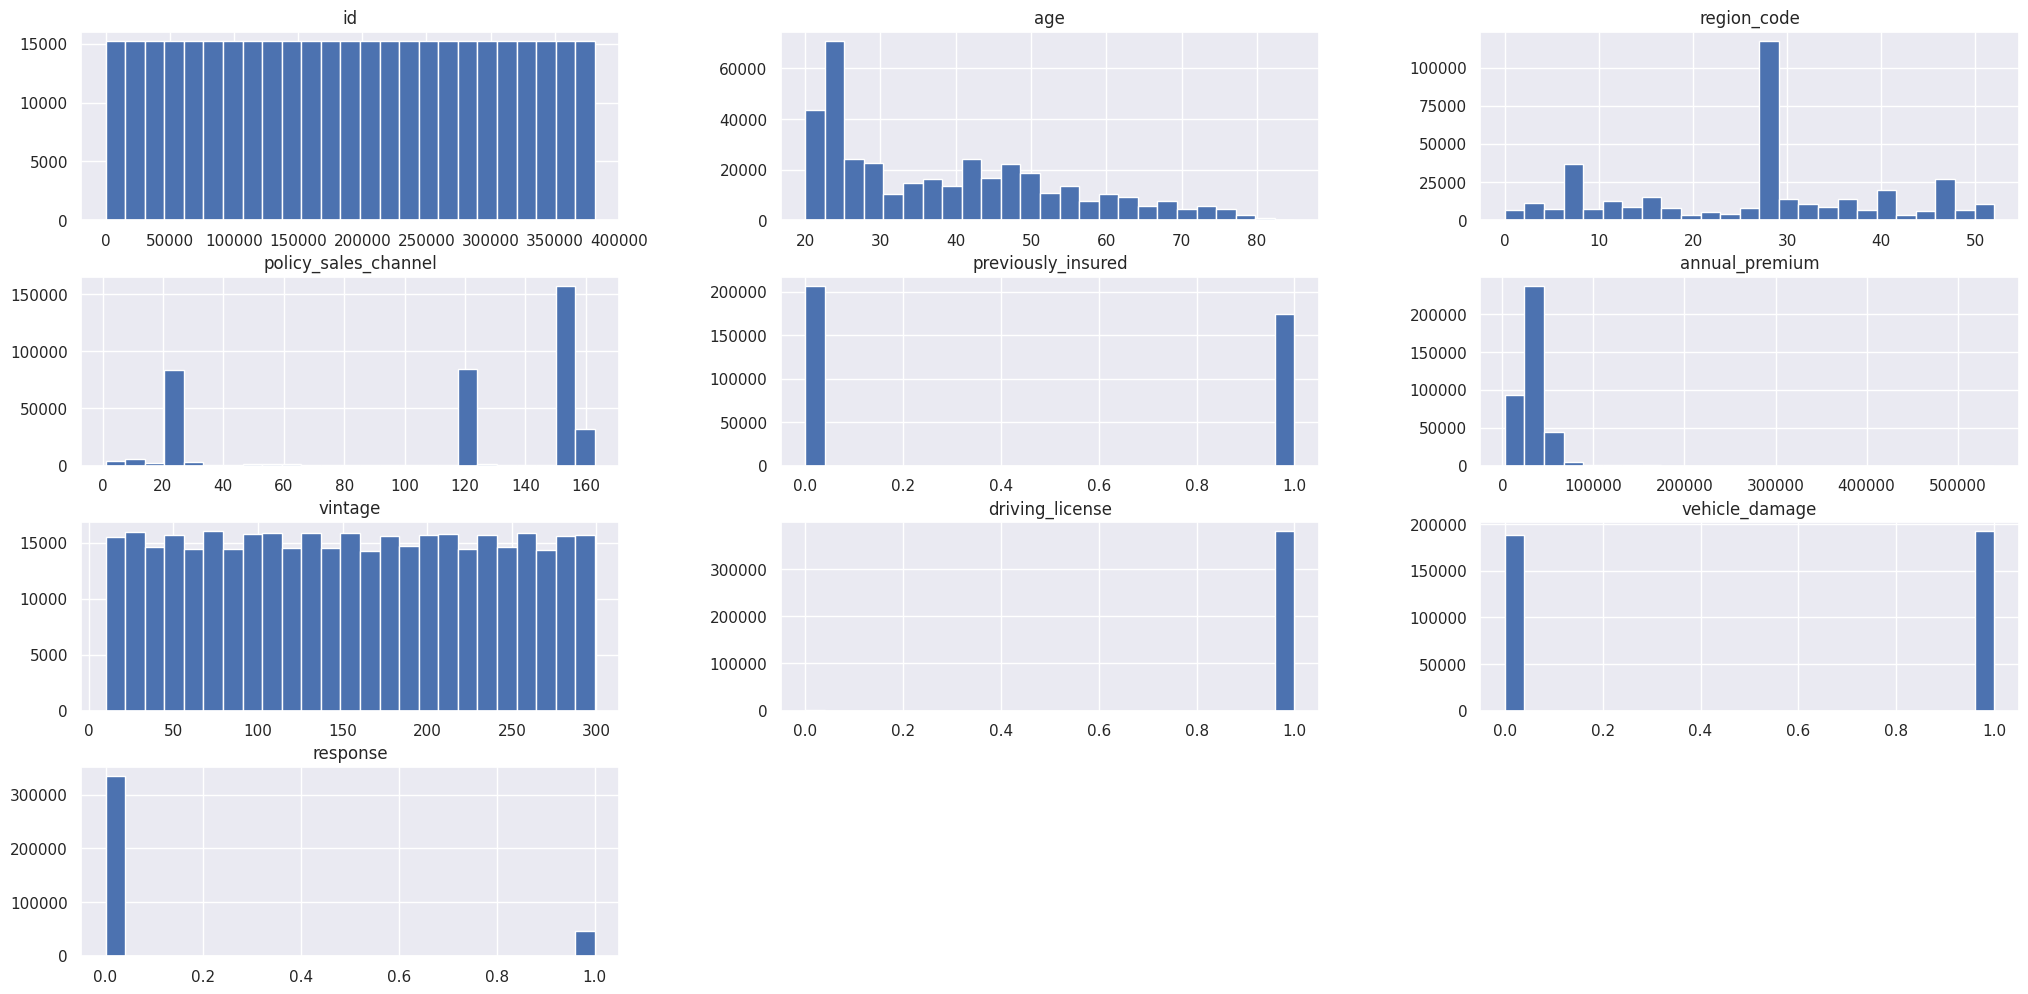

In [80]:
df3_num = df3.select_dtypes(include=['int64', 'float64'])

df3_num.hist(bins=25);

In [81]:
#response -> disparidade muito grande entre números de pessoas que não adquiriram o seguro veícular (0) e as que adquiriram (1).

### 3.1.2 Variável Categórica

In [82]:
df3['vehicle_age'].drop_duplicates()

0      < 1 Year
1      1-2 Year
27    > 2 Years
Name: vehicle_age, dtype: object

### 3.1.3 Análise exploratória de Dados Inicial e Feature Engineering

### H.1 Quanto maior a idade, maior a propensão do cliente em adquirir um seguro veícular.
**Verdadeiro** -> Nota-se maior concentração entre 40 e 50 anos dentre os que mostraram interesse no seguro veícular

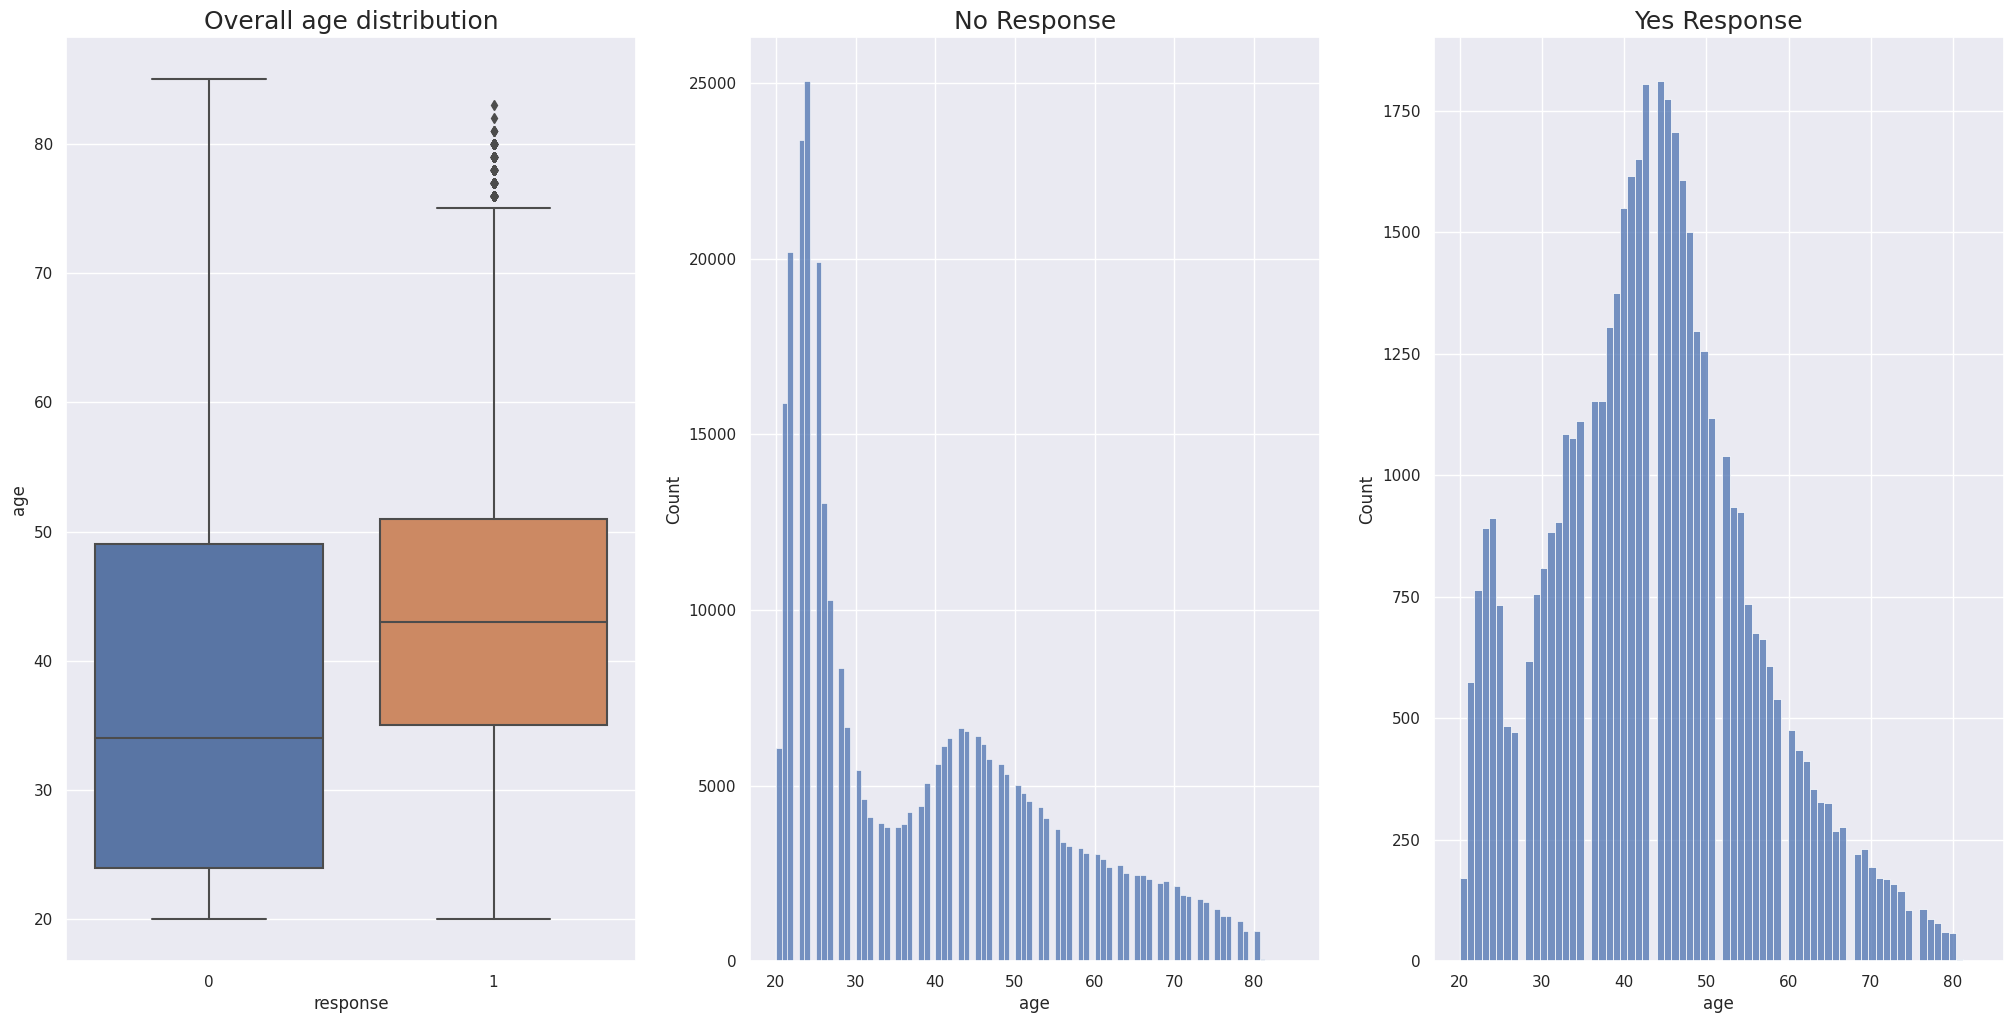

In [83]:
plt.subplot(1,3,1)
plt.title ('Overall age distribution', fontsize=18)
sns.boxplot(df3, x='response', y='age');

plt.subplot(1,3,2)
plt.title('No Response',fontsize=18)
aux = df3.loc[df3['response'] == 0, :]
sns.histplot(aux, x='age');

plt.subplot(1,3,3)
plt.title('Yes Response', fontsize=18)
aux = df3.loc[df3['response'] == 1, :]
sns.histplot(aux, x='age');

### H.2 Clientes que já ativaram/possuem o seguro veícular possuem menor propensão de adquirir um  novo plano de seguro veícular.

**Verdadeiro** -> IMPORTANTE: Essa amostragem pode demonstrar um vazamento de dados; algo que não confere aprendizado ao algoritmo. Basicamente, ele irá dar um resposta pronta ao modelo, onde 100% dos clientes com seguro não tem interesse de troca ou nova aquisição.

In [84]:
aux2 = pd.crosstab(df3['previously_insured'], df3['response'])
aux2 = aux2.apply(lambda x: x/x.sum(), axis=1)
aux2

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### H.3 Clientes que pagam mais caro pela assinatura possuem menor propensão a adquirir um plano de seguro veícular.
**Falso** -> Nota-se pela forma de ambas as distribuições (com ou sem interesse de compra), que a medidas de tendência central (média/mediana) não variam muito entre as distribuições.

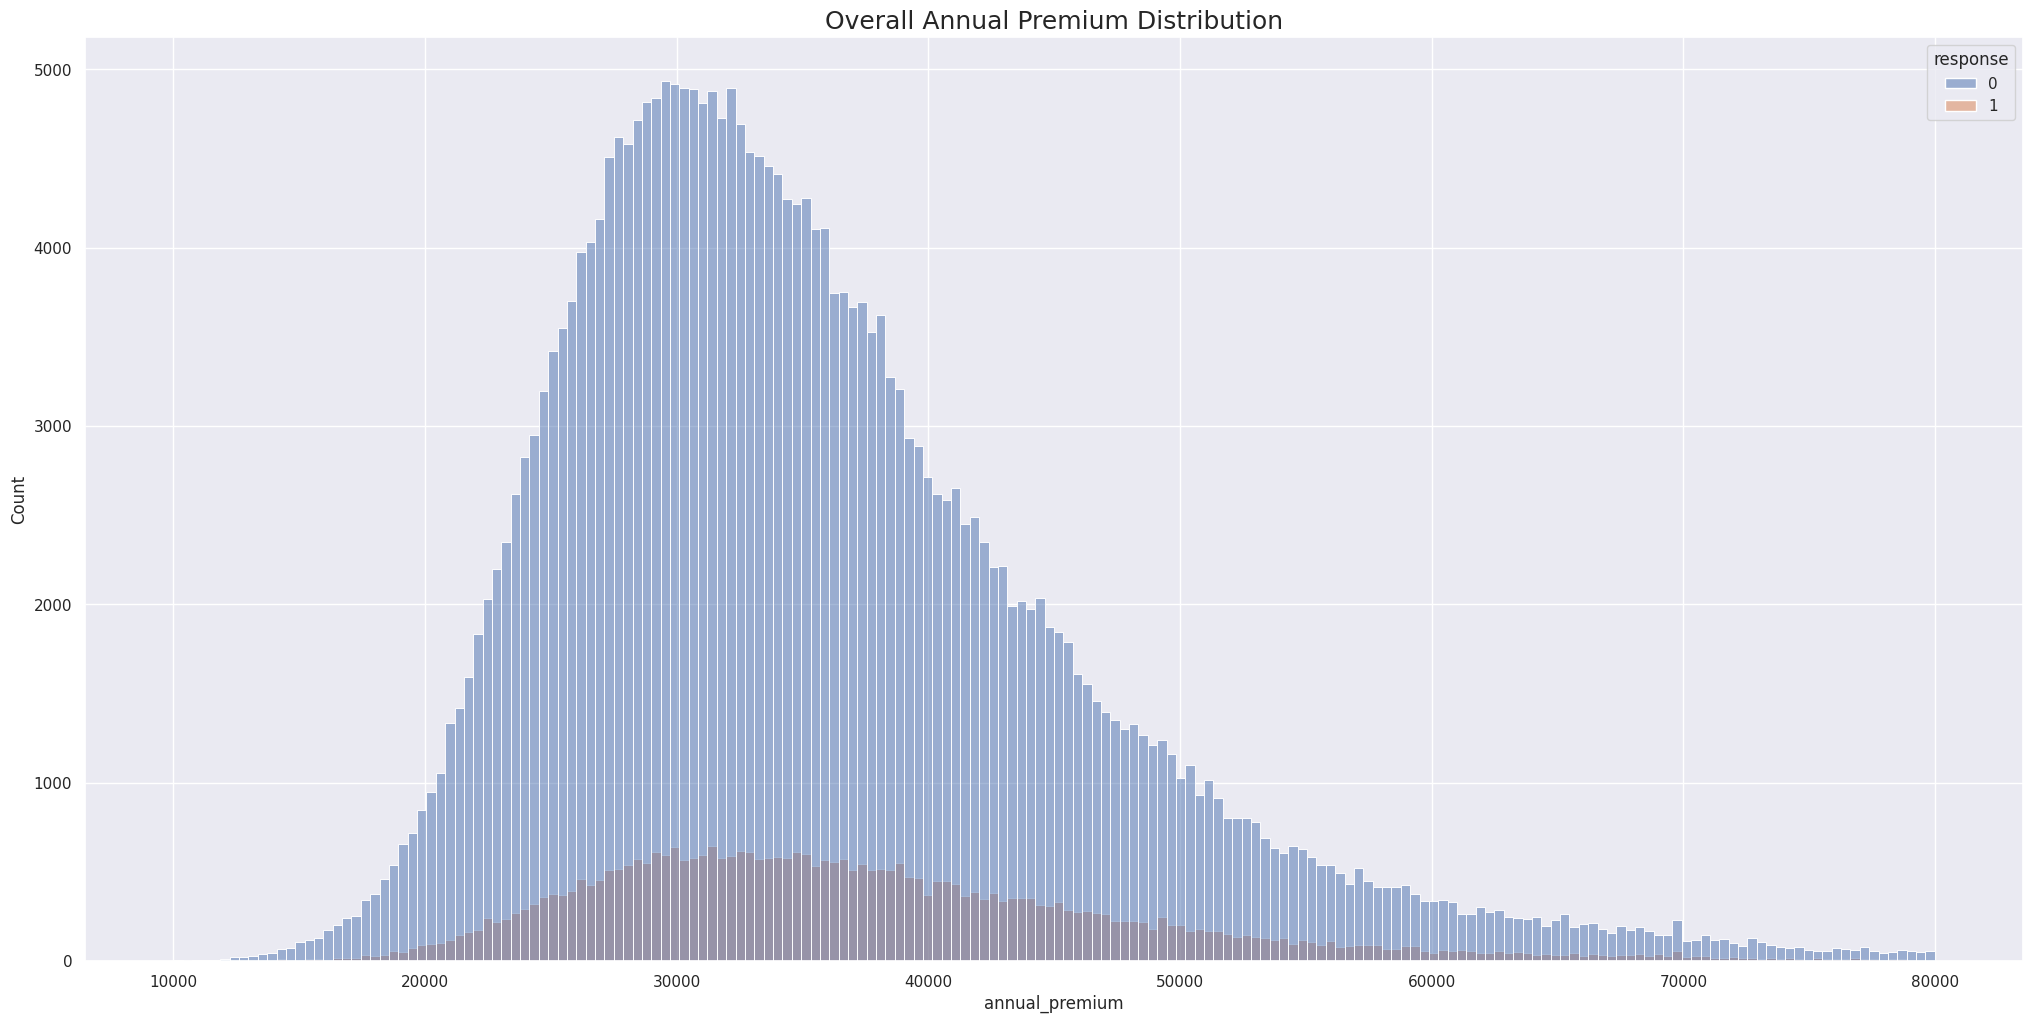

In [85]:
plt.title('Overall Annual Premium Distribution', fontsize=18)
aux3 = df3.loc[ (df3['annual_premium'] > 10000) & (df3['annual_premium'] < 80000), :]
sns.histplot(aux3, x='annual_premium', hue='response');

In [86]:
#Nota-se que há uma contagem muito grande (ordem de 65k de entradas) com annual premium padronizado no valor de $2630,00
    #possívelmente o 'plano básico/padrão' da seguradora de saúde

out1 = df3[['annual_premium','response']].groupby('annual_premium').count().sort_values('response',ascending=False).reset_index()
out1.head()

,annual_premium,response
0,2630.0,64877
1,69856.0,140
2,39008.0,41
3,38287.0,38
4,45179.0,38


### H.4 Clientes com mais dias de assinatura possuem maior propensão a adquirir um plano de seguro veícular.
**Falso** -> Nenhuma diferença observada relacionando-se dias de assinatura x interesse de compra

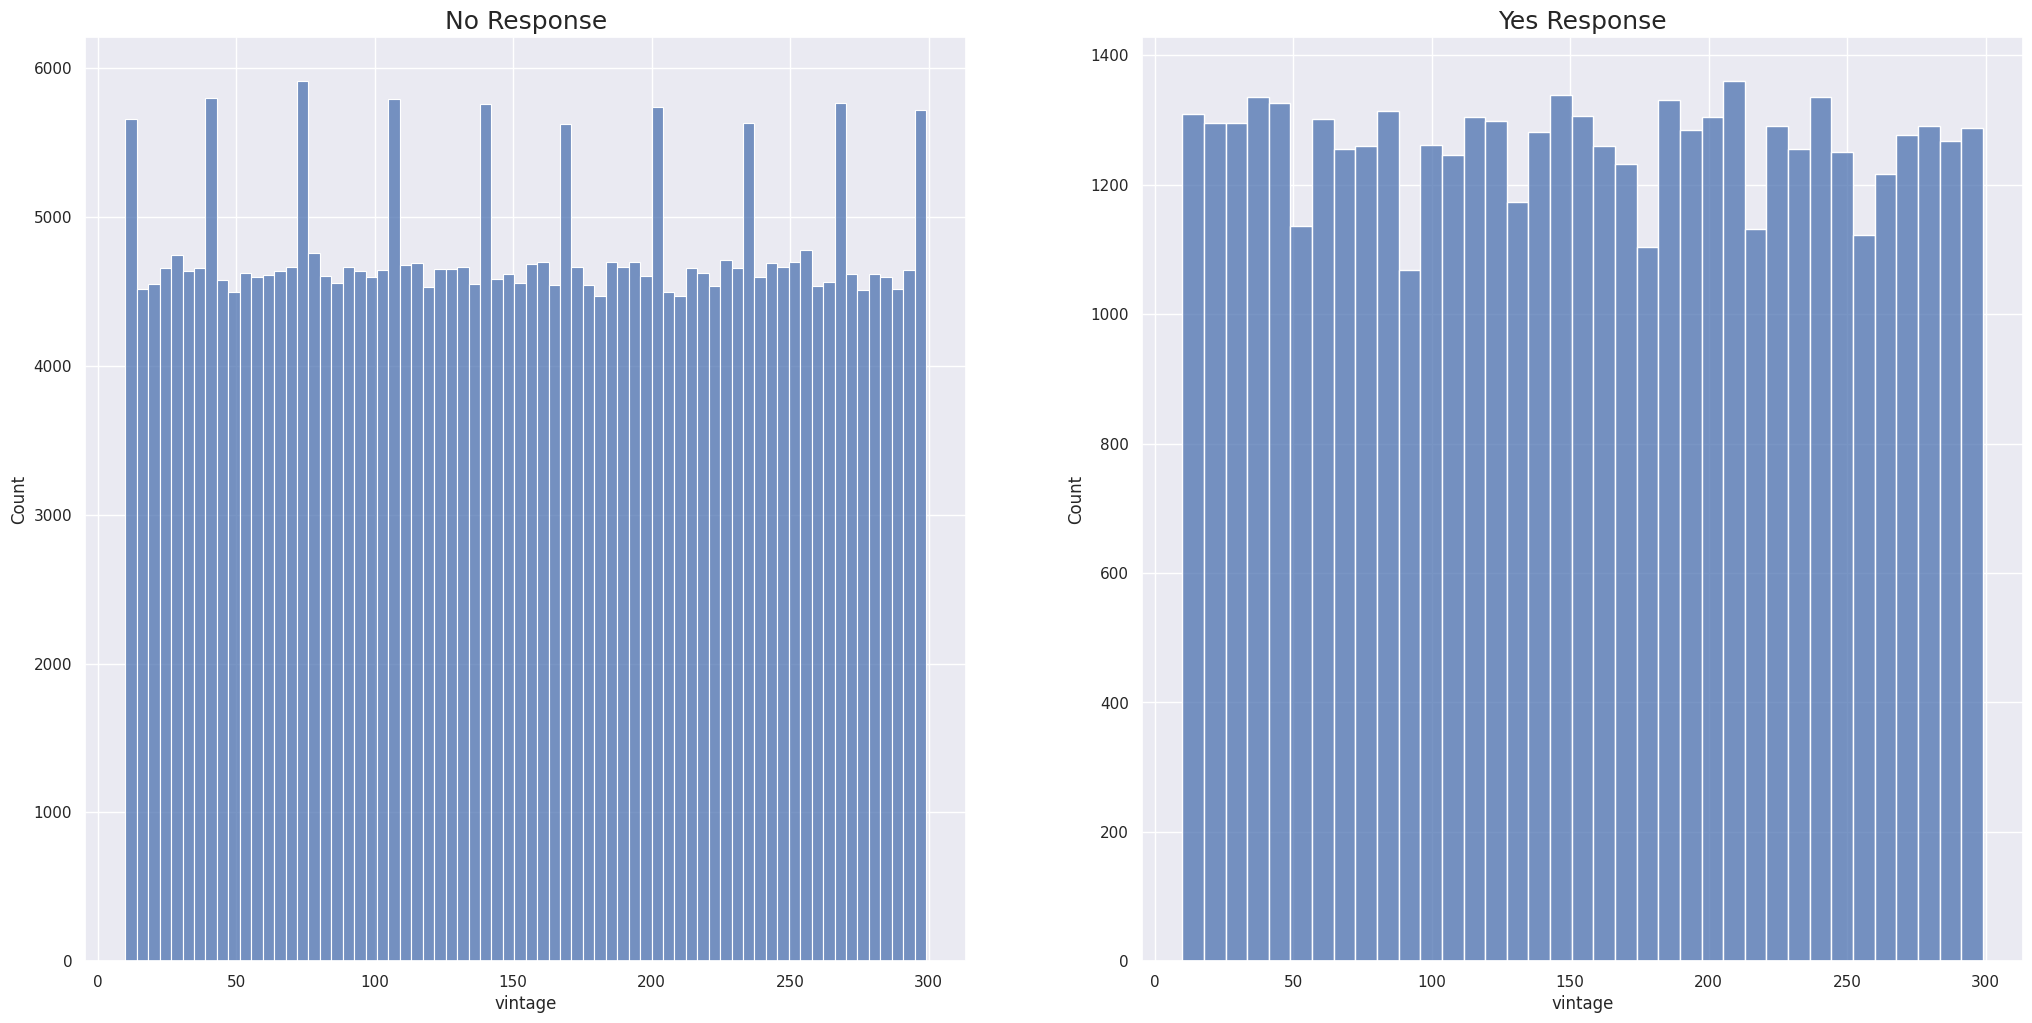

In [87]:
plt.subplot(1,2,1)
plt.title('No Response', fontsize=18)
aux4 = df3.loc[df3['response'] == 0, :]
sns.histplot(aux4, x='vintage');

plt.subplot(1,2,2)
plt.title('Yes Response', fontsize=18)
aux4 = df3.loc[df3['response'] == 1, :]
sns.histplot(aux4, x='vintage');

### H.5 Clientes com licença de habilitação são mais propensos a adquirir um plano de seguro veícular.
**Verdadeiro** -> Proporcionalmente, houve maior interesse de compra por parte de clientes com carteira de habilitação

In [88]:
aux5 = pd.crosstab(df3['driving_license'], df3['response'])
aux5 = aux5.apply(lambda x: x/x.sum(), axis=1)
aux5

response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


### H.6 Clientes com veículos mais antigos são mais propensos a adquirir um plano de seguro veícular.
**Verdadeiro** -> proporcionalmente, para carros de >2 anos de idade despertam maior interesse de compra de seguro em comparação aos demais

In [89]:
df3[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.434285
1,< 1 Year,0,0.413488
2,1-2 Year,1,0.091328
3,> 2 Years,0,0.029663
4,< 1 Year,1,0.018897
5,> 2 Years,1,0.012338


In [90]:
#Atribuição de score para a idade do carro
vehicle_age_dict = {'< 1 Year': 1,
                    '1-2 Year': 2,
                    '> 2 Years': 3}
df3['vehicle_age_score'] = df3['vehicle_age'].map(vehicle_age_dict)

### H.7 Clientes com veículos já danificados são mais propensos a adquirir um plano de seguro veícular.
**Verdadeiro** -> Proporção percentual muito maior de interessados em compra de seguro entre aqueles que possuem veículos danificados

In [91]:
aux7 = pd.crosstab(df3['vehicle_damage'], df3['response']).apply(lambda x: x/x.sum(), axis = 1)
aux7

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


### H.8 Clientes de determinada região são mais propensos a adquirir um plano de seguro veícular.
**Falso** -> Proporcionalmente, não há uma região específica onde o interesse de compra se destaque

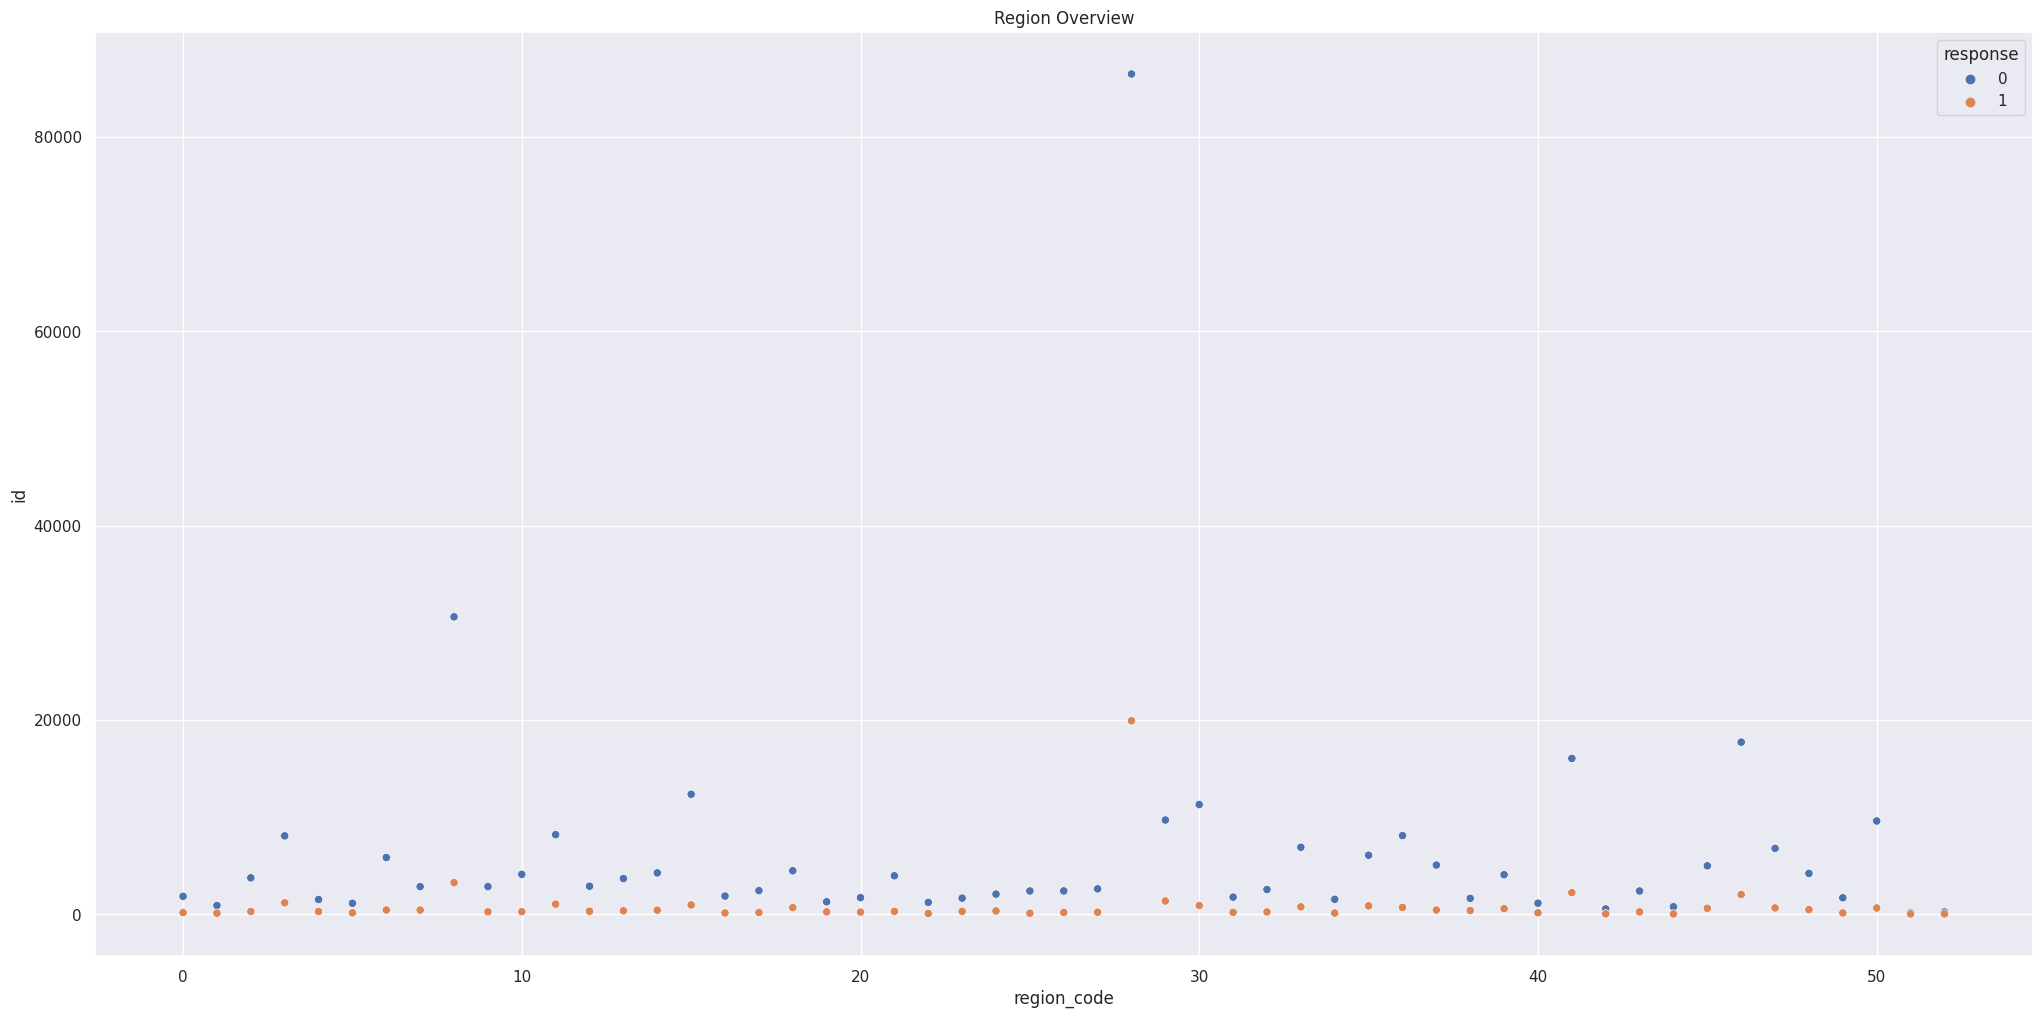

In [92]:
plt.title('Region Overview')
aux8 = df3[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(aux8, x='region_code', y='id', hue='response');

### H.9 Verificar se existe alguma discrepância em proporção de interessados em adquirir seguro de acordo com o código de contato
**Verdadeiro** -> Sim, alguns códigos possuem proporção muito maior de interessados.

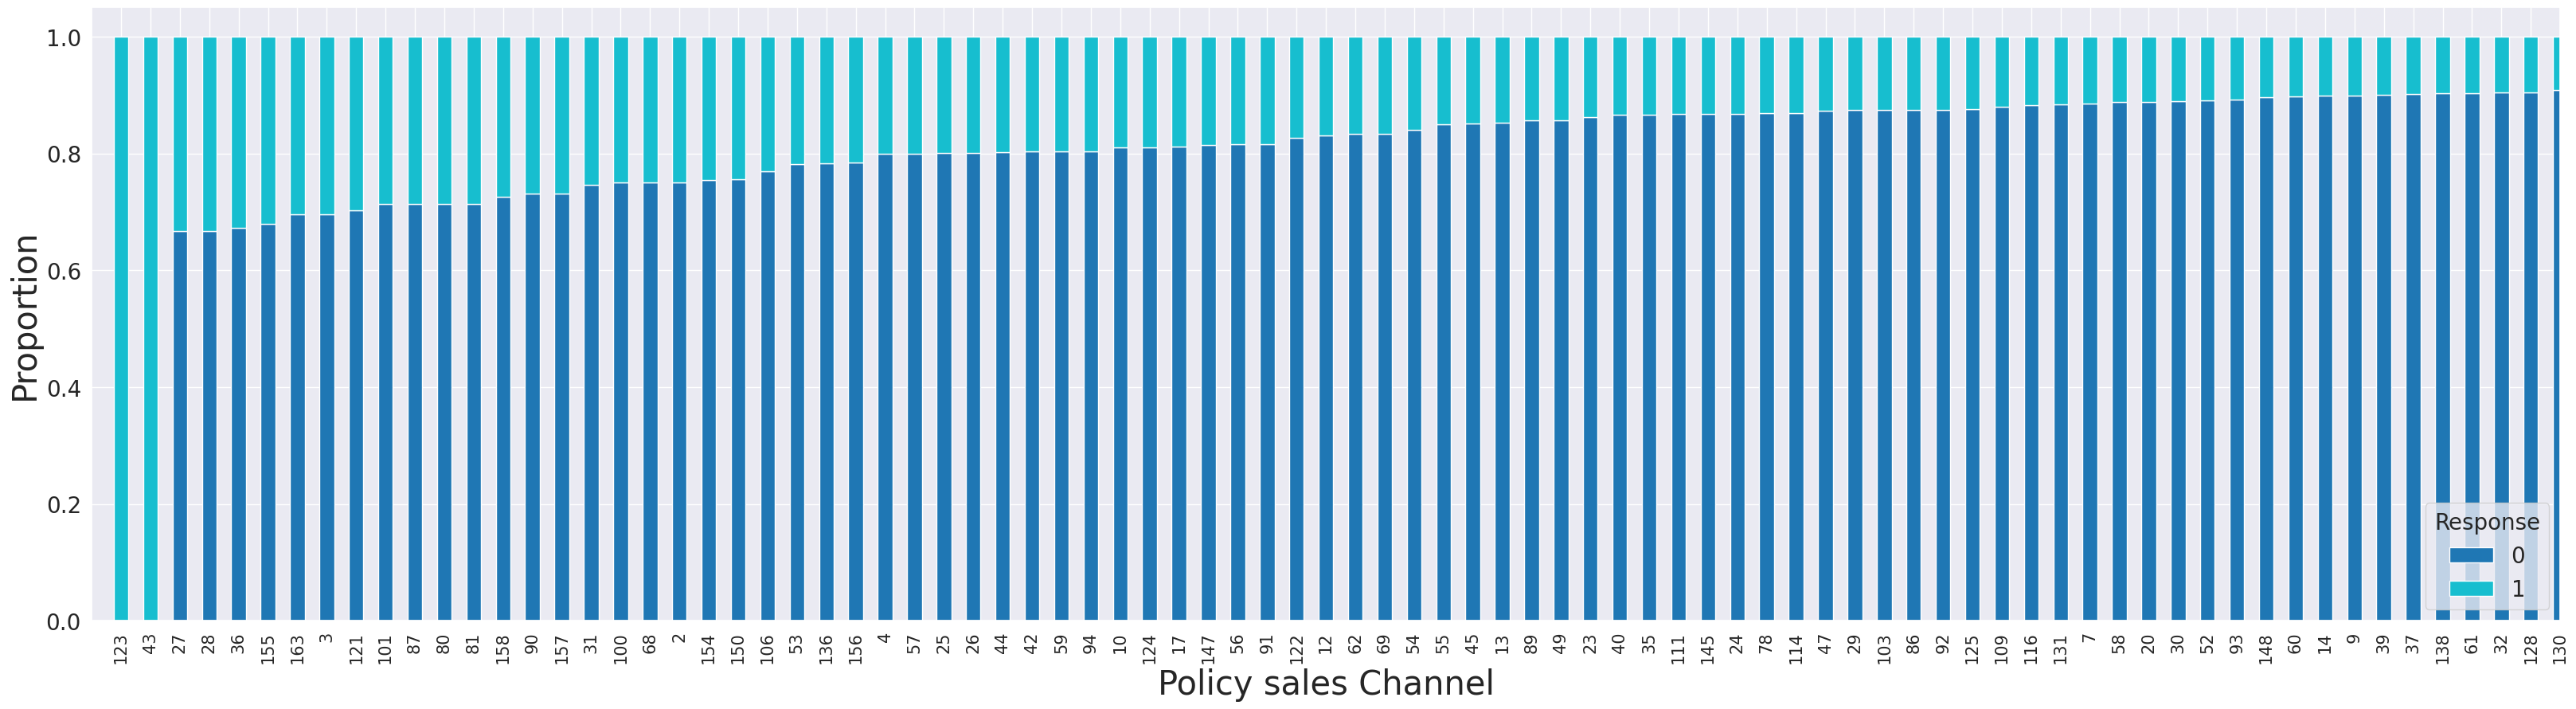

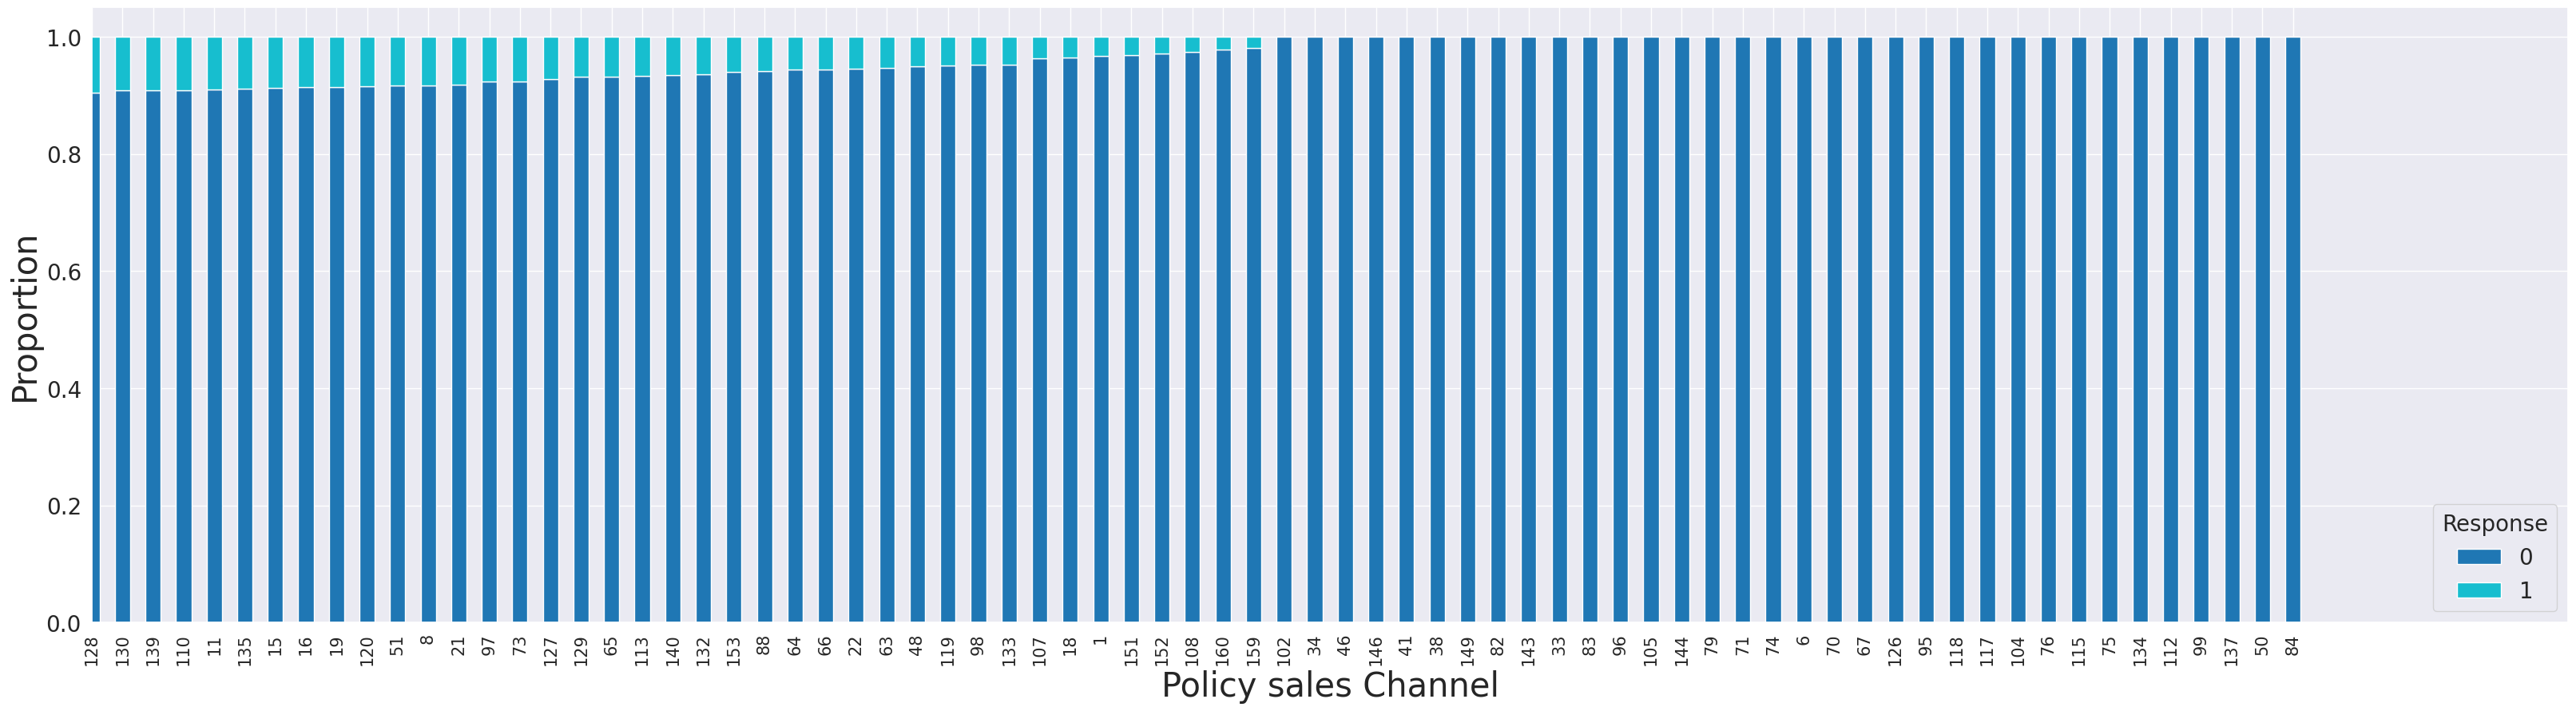

In [93]:
aux9 = pd.crosstab(df3['policy_sales_channel'], df3['response']).apply(lambda x: x/x.sum(), axis = 1).sort_values(1, ascending=False)

ax1 = aux9.plot(kind='bar',
          stacked=True,
          colormap='tab10',
          figsize = (40, 10));
plt.xlabel('Policy sales Channel',fontsize=30);
plt.xticks(fontsize=15);
plt.xlim(-1, 83);
plt.ylabel('Proportion', fontsize = 30);
plt.yticks(fontsize=20);

ax1.legend(loc='lower right', prop={'size': 20}, title_fontsize= 20, title= 'Response');

ax2 = aux9.plot(kind='bar',
          stacked=True,
          colormap='tab10',
          figsize = (40, 10));
plt.xlabel('Policy sales Channel',fontsize=30);
plt.xticks(fontsize=15);
plt.xlim(82, 163);
plt.ylabel('Proportion', fontsize = 30);
plt.yticks(fontsize=20);

ax2.legend(loc='lower right', prop={'size': 20}, title_fontsize= 20, title= 'Response');

In [94]:
#Criação de dicionário para atribuição de score(pontuação) aos canais com maior proporção de respostas
aux9_2 = df3[['policy_sales_channel', 'response']].groupby('policy_sales_channel').value_counts(normalize=True).reset_index()
aux9_2 = aux9_2.drop(aux9_2[aux9_2['response'] == 0].index).sort_values(0)
aux9_2['scored_sales_channel'] = aux9_2[0].apply(lambda x: 5 if x > 0.3 else
                                                 4 if (x <= 0.3) & (x > 0.25) else
                                                 3 if (x <= 0.25) & (x > 0.2) else
                                                 2 if (x <= 0.2) & (x > 0.1) else 1)
scored_sales_channel = {channel: score for channel, score in zip(aux9_2['policy_sales_channel'], aux9_2['scored_sales_channel'])}

#Atribuição dos valores de score aos seus respectivos canais no dataframe original
df3['scored_sales_channel'] = df3['policy_sales_channel'].map(scored_sales_channel)
df3['scored_sales_channel'].fillna(1, inplace=True)
df3['scored_sales_channel']= df3['scored_sales_channel'].astype(int64)

### 3.1.4 Resumo da Análise exploratória de dados Inicial

In [95]:
from tabulate import tabulate

In [96]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Verdadeira', 'Alta'],
       ['H2', 'Verdadeira', 'Baixa'], #Constata possível vazamento de dados: o não interesse total em adquirir novo seguro veícular (ou mudar de contrato) dentre os que já possuem
       ['H3', 'Falso', 'Baixa'],
       ['H4', 'Falso', 'Baixa'],
       ['H5', 'Verdadeira', 'Média'], #Diferencial de 7% quanto ao interesse de aquisição de seguro entre classes
       ['H6', 'Verdadeira', 'Alta'],  #Proporcionalmente, quase 50% dos que possuem carros acima de 2 anos de idade demonstram interesse na aquisição de seguro 
       ['H7', 'Verdadeira', 'Alta'],  #Proporcionalmente mais de 10% de diferença do nº de interessados dentre aqueles com veículo previamente danificado
       ['H8', 'Falso', 'Baixa'],
       ['H9', 'Verdadeira', 'Alta']] #Há predominãncia de interessados em regiões específicas

print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Verdadeira   Baixa
H3           Falso        Baixa
H4           Falso        Baixa
H5           Verdadeira   Média
H6           Verdadeira   Alta
H7           Verdadeira   Alta
H8           Falso        Baixa
H9           Verdadeira   Alta


## 3.2 Análise Bivariada

In [97]:
#Criação de dicionário para atribuição de score(pontuação) as regiões com maior proporção de respostas, combinadas com registros de carros danificados
aux8_2 = df3[['region_code', 'vehicle_damage', 'response']].groupby('region_code').value_counts(normalize=True).reset_index()
aux8_2 = aux8_2.loc[(aux8_2['response'] == 1) & (aux8_2['vehicle_damage'] == 1), :].sort_values(0)
aux8_2['region_score'] = aux8_2[0].apply(lambda x: 4 if x >= 0.15 else
                                        3 if (x < 0.15) & (x >= 0.10) else
                                        2 if (x < 0.10) & (x >= 0.05) else 1)
region_insured_dict = {region: score for region, score in zip(aux8_2['region_code'], aux8_2['region_score'])}

#Atribuição dos valores de score as suas respectivas regiões no dataframe original
df3['region_score'] = df3['region_code'].map(region_insured_dict)
df3['region_score'].fillna(1, inplace=True)
df3['region_score'] = df3['region_score'].astype(int64)

In [98]:
df3.dtypes

id                        int64
age                       int64
region_code               int64
policy_sales_channel      int64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age              object
vehicle_damage            int64
response                  int64
vehicle_age_score         int64
scored_sales_channel      int64
region_score              int64
dtype: object

In [99]:
df3.drop(['annual_premium', 'vintage'], axis=1)
reorder_columns = ['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'driving_license', 'vehicle_age', 
       'vehicle_damage', 'scored_sales_channel', 'vehicle_age_score', 
       'region_score','response']

df3 = df3.reindex(columns=reorder_columns)

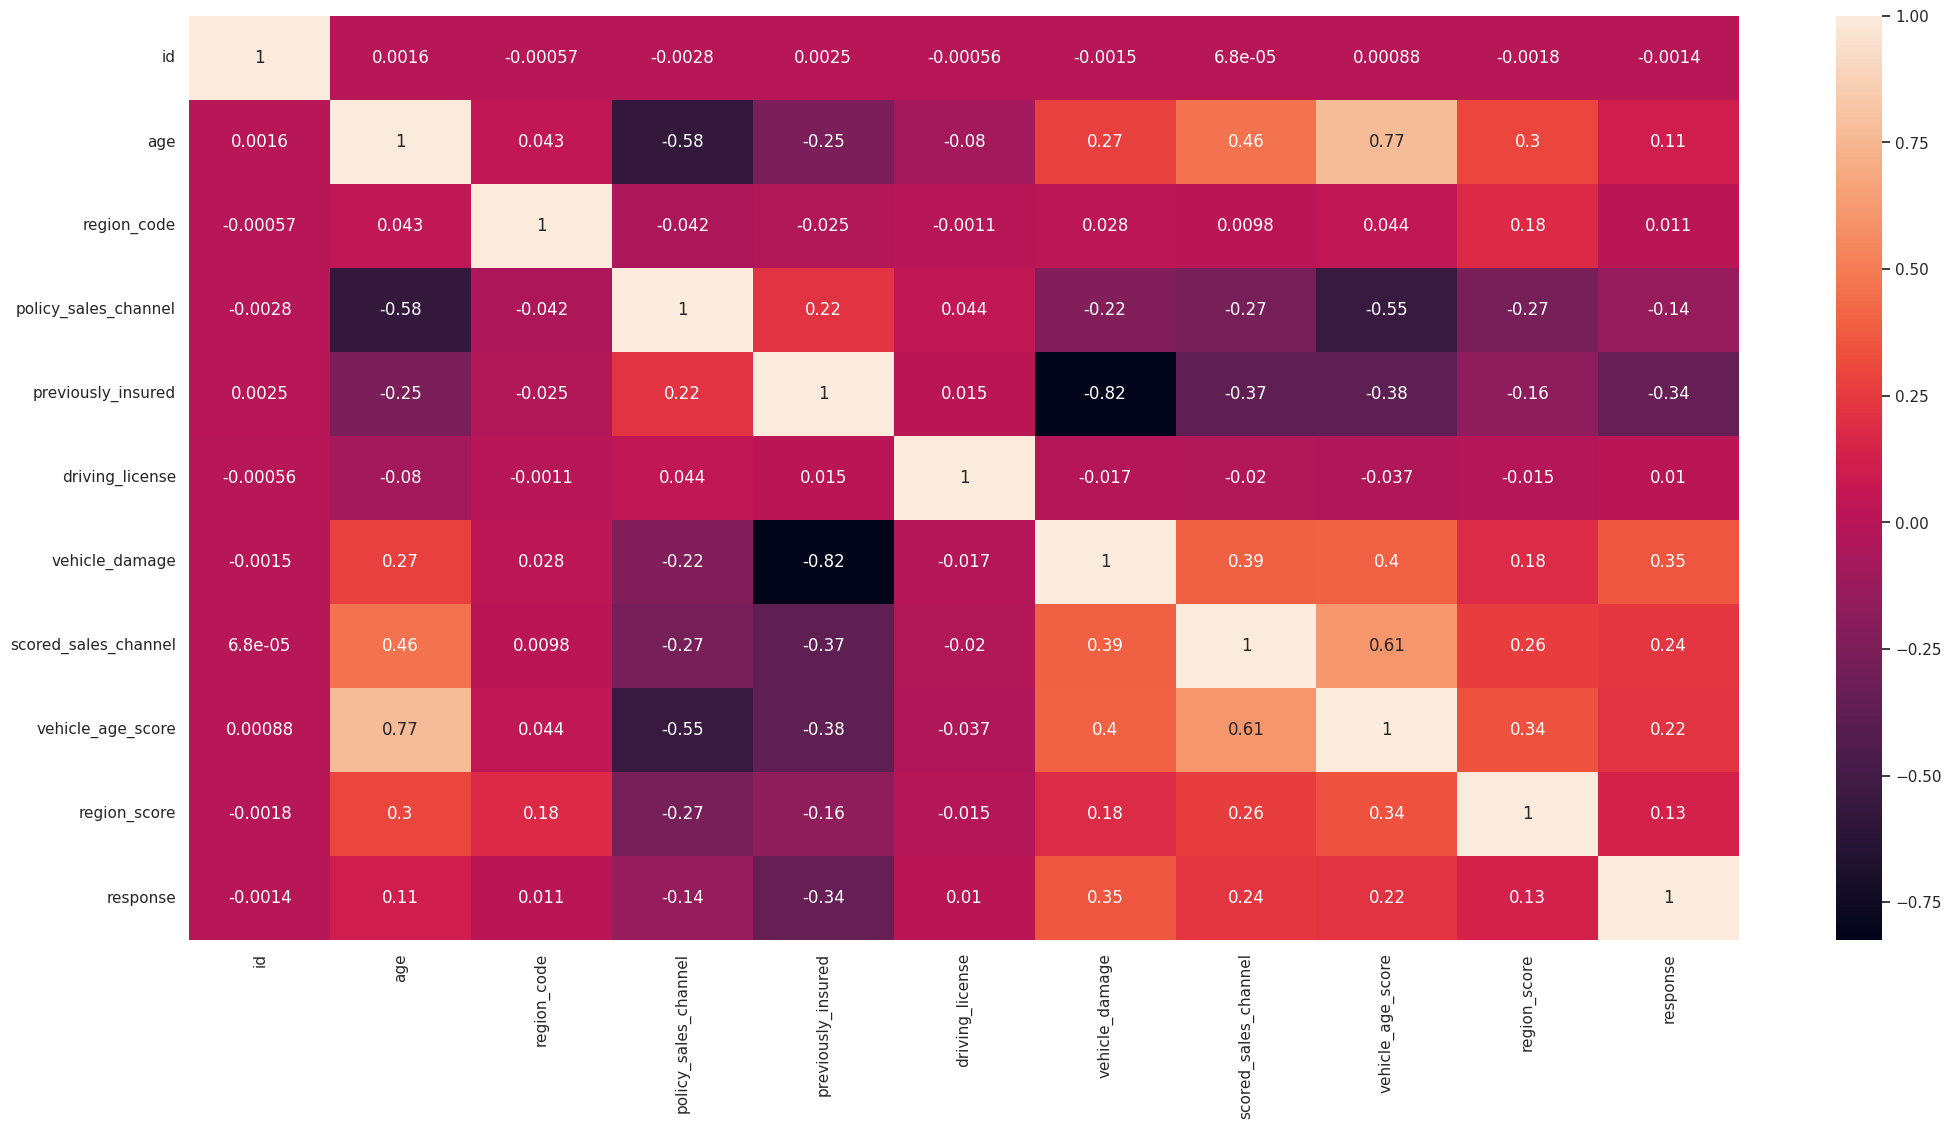

In [100]:
df3_num = df3.select_dtypes(include=['int64', 'float64'])
correlation = df3_num.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [101]:
df3.head()

,id,age,region_code,policy_sales_channel,previously_insured,driving_license,vehicle_age,vehicle_damage,scored_sales_channel,vehicle_age_score,region_score,response
0,7,23,11,152,0,1,< 1 Year,1,1,1,3,0
1,13,41,15,14,1,1,1-2 Year,0,2,2,2,0
2,18,25,35,152,1,1,< 1 Year,0,1,1,3,0
3,31,26,8,160,0,1,< 1 Year,0,1,1,2,0
4,39,45,8,124,0,1,1-2 Year,1,2,2,2,0


# 4.0 DATA PREPARATION

In [102]:
df4 = df3.copy()

In [103]:
df4_num = df4.select_dtypes(include=['int64', 'float64'])
df4_num.head()

,id,age,region_code,policy_sales_channel,previously_insured,driving_license,vehicle_damage,scored_sales_channel,vehicle_age_score,region_score,response
0,7,23,11,152,0,1,1,1,1,3,0
1,13,41,15,14,1,1,0,2,2,2,0
2,18,25,35,152,1,1,0,1,1,3,0
3,31,26,8,160,0,1,0,1,1,2,0
4,39,45,8,124,0,1,1,2,2,2,0


## 4.1 Normalização

## 4.2 Padronização (Reescaling)

In [104]:
#Analisa-se a ocorrência de outliers para aplicação do método de reescalonamento

mms = MinMaxScaler()

df4['region_code'] = mms.fit_transform(df4[['region_code']].values)
#pickle.dump(mms, open('models/region_code_scaler.pkl'), 'wb')

df4['policy_sales_channel'] = mms.fit_transform(df4[['policy_sales_channel']].values)
#pickle.dump(mms, open('models/policy_sales_channel_scaler.pkl'), 'wb')

df4['age'] = mms.fit_transform(df4[['age']].values)
#pickle.dump(mms, open('models/age_scaler.pkl'), 'wb')

## 4.3 Transformação
    *Etapa já realizada durante o feature engineering, com a atribuição de rótulos de acordo com a idade do veículo (coluna vehicle_age_score)

## 4.4 Balanceamento dos dados

In [105]:
df4 = df4.drop('vehicle_age', axis=1)

In [106]:
x_resample = df4[['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'driving_license', 'vehicle_damage',
       'scored_sales_channel', 'vehicle_age_score', 'region_score',]]
x_resample.head()

,id,age,region_code,policy_sales_channel,previously_insured,driving_license,vehicle_damage,scored_sales_channel,vehicle_age_score,region_score
0,7,0.046154,0.211538,0.932099,0,1,1,1,1,3
1,13,0.323077,0.288462,0.080247,1,1,0,2,2,2
2,18,0.076923,0.673077,0.932099,1,1,0,1,1,3
3,31,0.092308,0.153846,0.981481,0,1,0,1,1,2
4,39,0.384615,0.153846,0.759259,0,1,1,2,2,2


In [107]:
x_resample = df4[['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'driving_license', 'vehicle_damage',
       'scored_sales_channel', 'vehicle_age_score', 'region_score',]]
y_resample = df4['response']

smote = SMOTE(random_state = 32)
X_smote_res, y_smote_res = smote.fit_resample(x_resample, y_resample)

In [108]:
counter = Counter(y_smote_res)
print(counter)

Counter({0: 334399, 1: 334399})


In [118]:
#Re-sampled dataframe
df4 = pd.concat([X_smote_res, y_smote_res], axis=1)

# 5.0 FEATURE SELECTION

In [119]:
df5 = df4.copy()

## 5.1 Train-Test Split

In [120]:
df5.head()

,id,age,region_code,policy_sales_channel,previously_insured,driving_license,vehicle_damage,scored_sales_channel,vehicle_age_score,region_score,response
0,7,0.046154,0.211538,0.932099,0,1,1,1,1,3,0
1,13,0.323077,0.288462,0.080247,1,1,0,2,2,2,0
2,18,0.076923,0.673077,0.932099,1,1,0,1,1,3,0
3,31,0.092308,0.153846,0.981481,0,1,0,1,1,2,0
4,39,0.384615,0.153846,0.759259,0,1,1,2,2,2,0
